## Day 30 Lecture 2 Assignment

In this assignment, we will learn about random forests. We will use the google play store dataset loaded below.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
reviews = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/googleplaystore.csv')

reviews.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


#Feature Selection
Select which columns are best suited to predict whether the rating is above 4.5
* Recall the [assumptions](https://bccvl.org.au/algorithms-exposed-random-forest/#:~:text=ASSUMPTIONS,are%20ordinal%20or%20non%2Dordinal.)

* Strong Multicollinearity can impact the random forest results.



##Iteration One

In [ ]:
#I know that this is my target variable. 
target = 'Rating'

In [ ]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [ ]:
#The application ID is not necessary for this predictive process. 
reviews['App'].value_counts

#X is my dataframe of explanatory values.
X = reviews.drop(columns='App')

#Data Processing

 Process the data (including transforming to the correct column type, removing missing values, creating dummy variables, and removing irrelevant variables)


##Iteration One

###Categories


In [ ]:
X.columns

Index(['Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price',
       'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver'],
      dtype='object')

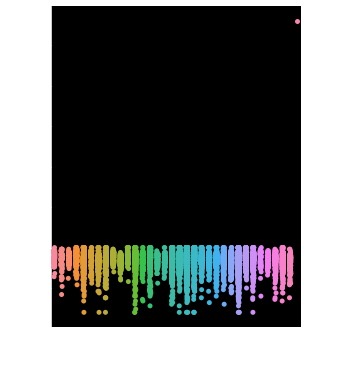

In [ ]:
sns.catplot(x='Category', y=target, data=reviews)

In [ ]:
X[X['Rating'] > 5]
#Drop anything greater than 5? The Content Rating is null. I should do something else.  

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


####Missingness 

I'm flagging this here because I'm uncertain where this decision should be at in my processing. Should it be at the beginning? In the middle? Do I walk away and come back to it?

In [ ]:
#A summary of missing variables represented as a percentage of the total missing content. 
def missingness_summary(df, print_log=False, sort='ascending'):
  s = df.isnull().sum()*100/df.isnull().count()
    
  if sort.lower() == 'ascending':
    s = s.sort_values(ascending=True)
  elif sort.lower() == 'descending':
    s = s.sort_values(ascending=False)  
  if print_log: 
    print(s)
  
  return pd.Series(s)

My Target Variable is rating. I'll drop those from the dataset for now. I suppose if I had a good enough prediction model, I could predict the rating on these. Alas, I'm building my dataset right now so I'll remove them an dall other nulls. This'll ensure uniformity  in my decision making if/when I revisit the feature selection process. 

Maybe. I don't know. I could be wrong. 

In [ ]:
missingness_summary(X)

Category           0.000000
Reviews            0.000000
Size               0.000000
Installs           0.000000
Price              0.000000
Genres             0.000000
Last Updated       0.000000
Type               0.009224
Content Rating     0.009224
Android Ver        0.027673
Current Ver        0.073794
Rating            13.596532
dtype: float64

In [ ]:
X = X.dropna()

In [ ]:
missingness_summary(X)

Category          0.0
Rating            0.0
Reviews           0.0
Size              0.0
Installs          0.0
Type              0.0
Price             0.0
Content Rating    0.0
Genres            0.0
Last Updated      0.0
Current Ver       0.0
Android Ver       0.0
dtype: float64

####Back to Categories.

In [ ]:
#Encode thingy that's in the first presentation. 
X['Category'].value_counts()

FAMILY                 1746
GAME                   1097
TOOLS                   733
PRODUCTIVITY            351
MEDICAL                 350
COMMUNICATION           328
FINANCE                 323
SPORTS                  319
PHOTOGRAPHY             317
LIFESTYLE               314
PERSONALIZATION         312
BUSINESS                303
HEALTH_AND_FITNESS      297
SOCIAL                  259
SHOPPING                238
NEWS_AND_MAGAZINES      233
TRAVEL_AND_LOCAL        226
DATING                  195
BOOKS_AND_REFERENCE     178
VIDEO_PLAYERS           160
EDUCATION               155
ENTERTAINMENT           149
MAPS_AND_NAVIGATION     124
FOOD_AND_DRINK          109
HOUSE_AND_HOME           76
WEATHER                  75
AUTO_AND_VEHICLES        73
LIBRARIES_AND_DEMO       64
ART_AND_DESIGN           61
COMICS                   58
PARENTING                50
EVENTS                   45
BEAUTY                   42
Name: Category, dtype: int64

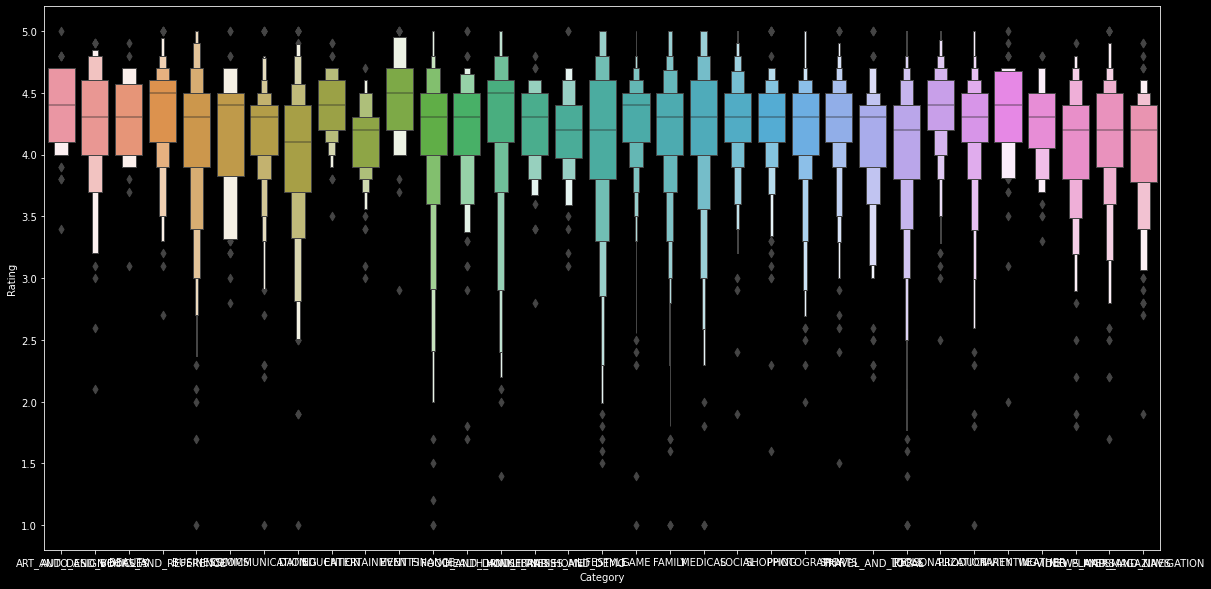

In [ ]:
plt.style.use(['dark_background'])
a4_dims = (20, 10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxenplot(x='Category', y=target, data=X)
plt.show()

I have a lot of categories. Visually, there doesn't look like a big impact on ratings and categories. It looks likes on average, the categories run pretty close to 4.5 based on ratings.

I'm going to go ahead and drop the categories feature. Maybe look at this with regards to ratings seperately should I be interested in - specifically - which categories get better ratings. 

In [ ]:
X = X.drop(columns='Category')

### Reviews

In [ ]:
X.columns

Index(['Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price',
       'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver'],
      dtype='object')

In [ ]:
#how many numerical columns are in this dataframe?
numerical_cols = [col_name for col_name in X.dtypes[X.dtypes.values == 'int64'].index 
                    if col_name not in ["id"] ]
len(numerical_cols)

0

####Convert to numeric

In [ ]:
X['Reviews'] = pd.to_numeric(X['Reviews'], errors='coerce')

In [ ]:
missingness_summary(X)

Rating            0.0
Reviews           0.0
Size              0.0
Installs          0.0
Type              0.0
Price             0.0
Content Rating    0.0
Genres            0.0
Last Updated      0.0
Current Ver       0.0
Android Ver       0.0
dtype: float64

### Size

I ran up a bit and took a look at the head for size and installs. It looks like they're a lot like the reviews were - they're numeric with an extra string in them. 

Size has an "M" to denote Milion, what else might it have? 
Installs has a plus sign to denote that it's over a certain amount. How do I find all the strings that might be in these datacolumns?

Later on I realized that size has to be handled differently from installs. That's alright. 

In [ ]:
X[X['Size'].str.contains('M', regex=False)]

,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...
10830,3.8,881,2.3M,"100,000+",Free,0,Everyone,News & Magazines,"January 20, 2014",1.5,1.6 and up
10834,4.0,7,2.6M,500+,Free,0,Everyone,Education,"June 18, 2017",1.0.0,4.1 and up
10836,4.5,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,5.0,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up


In [ ]:

X[~X['Size'].str.contains('M', regex=False)]

,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
37,4.1,36639,Varies with device,"5,000,000+",Free,0,Everyone,Art & Design,"July 14, 2018",Varies with device,2.3.3 and up
42,4.4,295221,Varies with device,"10,000,000+",Free,0,Everyone,Art & Design,"July 30, 2018",Varies with device,Varies with device
52,4.6,17057,Varies with device,"1,000,000+",Free,0,Everyone,Auto & Vehicles,"July 30, 2018",Varies with device,Varies with device
58,4.0,1403,201k,"100,000+",Free,0,Everyone,Auto & Vehicles,"August 26, 2014",1.0.1,2.2 and up
67,4.3,40211,Varies with device,"5,000,000+",Free,0,Everyone,Auto & Vehicles,"July 30, 2018",Varies with device,Varies with device
...,...,...,...,...,...,...,...,...,...,...,...
10765,3.4,622,Varies with device,"100,000+",Free,0,Mature 17+,Social,"May 23, 2018",Varies with device,Varies with device
10826,4.0,88486,Varies with device,"5,000,000+",Free,0,Mature 17+,Social,"March 23, 2018",Varies with device,Varies with device
10832,3.8,1195,582k,"100,000+",Free,0,Everyone,Weather,"February 16, 2014",6.0,2.1 and up
10833,4.8,44,619k,"1,000+",Free,0,Everyone,Books & Reference,"March 23, 2014",0.8,2.2 and up


What does these values mean? k - I know that means something. Now I can see that size, current ver. and Andrid Ver all have these same speculators on them. Do they relate to the target variable? They might. I would/could hypothesize that the type of technology that is available could impact/influence the rating. 

I mean, an application might have better performance on a better utility. the varies with device - versions might have better reviews than the other ones because they're working with the hardware that's avaible and they're more accessible. 

I have to leave that thought for right now. and go back to size. does size relate to the rating?

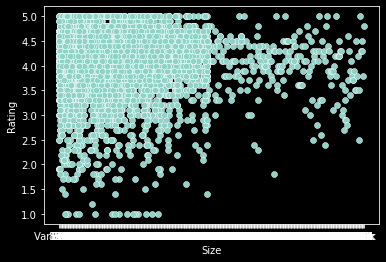

In [ ]:
sns.scatterplot(x="Size", y=target, data=X)

Yeesh! Would you look at that? They're all over the place! Okay. I have to clean the size variable and it's not going to be quick and easy. 

Where and how do I start? What's a good number to represent the varied data?
Maybe I should split them into categories. 
Dynamic (varies with device)
Small (k)
Medium (m)

In [ ]:
X[~X['Size'].str.contains('M', regex=False) & ~X['Size'].str.contains('V', regex=False) & ~X['Size'].str.contains('k', regex=False)]

,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver


In [ ]:
X.loc[X['Size'].str.contains('M', regex=False), 'Size'] = 'M'
X.head()

,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,4.1,159,M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,3.9,967,M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,4.7,87510,M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,4.5,215644,M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,4.3,967,M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [ ]:
X.loc[X['Size'].str.contains('k', regex=False), 'Size'] = 'K' 
X.loc[X['Size'].str.contains('K', regex=False)]

,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
58,4.0,1403,K,"100,000+",Free,0,Everyone,Auto & Vehicles,"August 26, 2014",1.0.1,2.2 and up
209,3.1,4034,K,"100,000+",Free,0,Everyone,Business,"September 11, 2015",3.0.1.11 (Build 311),2.2 and up
384,4.0,122498,K,"10,000,000+",Free,0,Everyone,Communication,"September 2, 2015",0.1.100944346,4.0.3 and up
450,4.0,9498,K,"1,000,000+",Free,0,Everyone,Communication,"June 7, 2016",5.28.0,2.3 and up
458,4.2,124346,K,"10,000,000+",Free,0,Everyone,Communication,"July 6, 2014",2.8,2.0 and up
...,...,...,...,...,...,...,...,...,...,...,...
10732,4.3,3268,K,"100,000+",Free,0,Everyone,Tools,"December 16, 2017",6.6,2.0 and up
10755,4.3,334,K,"10,000+",Free,0,Everyone,Maps & Navigation,"August 23, 2016",1.3,2.3.3 and up
10763,4.5,922,K,"50,000+",Free,0,Everyone,Entertainment,"September 20, 2014",1.1,1.6 and up
10832,3.8,1195,K,"100,000+",Free,0,Everyone,Weather,"February 16, 2014",6.0,2.1 and up


In [ ]:
X.loc[X['Size'].str.contains('V', regex=False), 'Size'] = 'V'
X.loc[X['Size'].str.contains('V', regex=False)]

,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
37,4.1,36639,V,"5,000,000+",Free,0,Everyone,Art & Design,"July 14, 2018",Varies with device,2.3.3 and up
42,4.4,295221,V,"10,000,000+",Free,0,Everyone,Art & Design,"July 30, 2018",Varies with device,Varies with device
52,4.6,17057,V,"1,000,000+",Free,0,Everyone,Auto & Vehicles,"July 30, 2018",Varies with device,Varies with device
67,4.3,40211,V,"5,000,000+",Free,0,Everyone,Auto & Vehicles,"July 30, 2018",Varies with device,Varies with device
68,3.9,356,V,"100,000+",Free,0,Everyone,Auto & Vehicles,"May 25, 2018",Varies with device,Varies with device
...,...,...,...,...,...,...,...,...,...,...,...
10713,4.4,3471,V,"100,000+",Free,0,Everyone,Weather,"July 24, 2018",Varies with device,Varies with device
10725,3.6,8,V,"1,000+",Free,0,Everyone,Maps & Navigation,"September 27, 2017",Varies with device,4.4 and up
10765,3.4,622,V,"100,000+",Free,0,Mature 17+,Social,"May 23, 2018",Varies with device,Varies with device
10826,4.0,88486,V,"5,000,000+",Free,0,Mature 17+,Social,"March 23, 2018",Varies with device,Varies with device


In [ ]:
X['Size'].value_counts()

M    7466
V    1637
K     257
Name: Size, dtype: int64

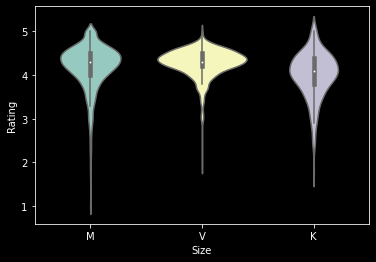

In [ ]:
sns.violinplot(x='Size', y=target, data=X)

In [ ]:
#convert these to a float because the AI can't handle strings.
X = pd.get_dummies(columns=['Size'], drop_first=True, data=X)

### Installs

This should be easy. Just remove the plus sign. 

In [ ]:
X.loc[~X['Installs'].str.contains('+', regex=False)]

,Rating,Reviews,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Size_M,Size_V


In [ ]:
X['Installs'] = X['Installs'].str.replace(',', "")
X['Installs'] = X['Installs'].str.replace('+', "")

In [ ]:
X['Installs'] = pd.to_numeric(X['Installs'], errors='coerce')

In [ ]:
X.head()

,Rating,Reviews,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Size_M,Size_V
0,4.1,159,10000,Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,1,0
1,3.9,967,500000,Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,1,0
2,4.7,87510,5000000,Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,1,0
3,4.5,215644,50000000,Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up,1,0
4,4.3,967,100000,Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,1,0


In [ ]:
missingness_summary(X)

Rating            0.0
Reviews           0.0
Installs          0.0
Type              0.0
Price             0.0
Content Rating    0.0
Genres            0.0
Last Updated      0.0
Current Ver       0.0
Android Ver       0.0
Size_M            0.0
Size_V            0.0
dtype: float64

### Type
I can get dummies on this one and set drop first to true. 

In [ ]:
X['Type'].value_counts()

Free    8715
Paid     645
Name: Type, dtype: int64

In [ ]:
X = pd.get_dummies(X, columns=['Type'], drop_first=True)
X.head()

,Rating,Reviews,Installs,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Size_M,Size_V,Type_Paid
0,4.1,159,10000,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,1,0,0
1,3.9,967,500000,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,1,0,0
2,4.7,87510,5000000,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,1,0,0
3,4.5,215644,50000000,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up,1,0,0
4,4.3,967,100000,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,1,0,0


###Price

what does price look like? Everything is an object in this set. . . 

In [ ]:
X['Price'].value_counts()

0          8715
$2.99       114
$0.99       106
$4.99        70
$1.99        59
           ... 
$19.40        1
$379.99       1
$4.84         1
$4.77         1
$1.29         1
Name: Price, Length: 73, dtype: int64

In [ ]:
X['Price'] = X['Price'].str.strip('$.')
X['Price'] = pd.to_numeric(X['Price'], errors='coerce')

In [ ]:
missingness_summary(X)

Rating            0.0
Reviews           0.0
Installs          0.0
Price             0.0
Content Rating    0.0
Genres            0.0
Last Updated      0.0
Current Ver       0.0
Android Ver       0.0
Size_M            0.0
Size_V            0.0
Type_Paid         0.0
dtype: float64

###Content Rating

In [ ]:
X['Content Rating'].value_counts()


Everyone           7414
Teen               1084
Mature 17+          461
Everyone 10+        397
Adults only 18+       3
Unrated               1
Name: Content Rating, dtype: int64

In [ ]:
#Update a column with the new information.
def col_fix(col, val, new_val):
  X.loc[X[col].str.contains(val, regex=False), col] = new_val 

In [ ]:
col_fix('Content Rating', '+', 'M')
col_fix('Content Rating', 'd', 'M')
X['Content Rating'].value_counts()

Everyone    7414
Teen        1084
M            862
Name: Content Rating, dtype: int64

In [ ]:
X['Content Rating'] = pd.get_dummies(X, columns=['Content Rating'], drop_first=True)

In [ ]:
X.head()

,Rating,Reviews,Installs,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Size_M,Size_V,Type_Paid
0,4.1,159,10000,0.0,4.1,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,1,0,0
1,3.9,967,500000,0.0,3.9,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,1,0,0
2,4.7,87510,5000000,0.0,4.7,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,1,0,0
3,4.5,215644,50000000,0.0,4.5,Art & Design,"June 8, 2018",Varies with device,4.2 and up,1,0,0
4,4.3,967,100000,0.0,4.3,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,1,0,0


In [ ]:
X['Content Rating'].value_counts()

4.4    1108
4.3    1076
4.5    1037
4.2     951
4.6     823
4.1     707
4.0     567
4.7     499
3.9     386
3.8     303
5.0     274
3.7     239
4.8     234
3.6     174
3.5     163
3.4     128
3.3     102
4.9      87
3.0      83
3.1      69
3.2      63
2.9      45
2.8      42
2.6      25
2.7      25
2.5      21
2.3      20
2.4      19
1.0      16
2.2      14
1.9      13
2.0      12
1.8       8
1.7       8
2.1       8
1.6       4
1.5       3
1.4       3
1.2       1
Name: Content Rating, dtype: int64

### Genres
Not more text columns! Genres has 115 categories and a few datapoints that belong to more than one category. 

Are ratings related to genres? This will help determine if I should try and split these or not. 


In [ ]:
X['Genres'].value_counts()

Tools                  732
Entertainment          533
Education              468
Action                 358
Productivity           351
                      ... 
Racing;Pretend Play      1
Puzzle;Education         1
Lifestyle;Education      1
Strategy;Creativity      1
Strategy;Education       1
Name: Genres, Length: 115, dtype: int64

In [ ]:
 X.loc[~X['Genres'].str.contains(';', regex=False)] 

,Rating,Reviews,Installs,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Size_M,Size_V,Type_Paid
0,4.1,159,10000,0.0,4.1,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,1,0,0
2,4.7,87510,5000000,0.0,4.7,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,1,0,0
3,4.5,215644,50000000,0.0,4.5,Art & Design,"June 8, 2018",Varies with device,4.2 and up,1,0,0
5,4.4,167,50000,0.0,4.4,Art & Design,"March 26, 2017",1.0,2.3 and up,1,0,0
6,3.8,178,50000,0.0,3.8,Art & Design,"April 26, 2018",1.1,4.0.3 and up,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10834,4.0,7,500,0.0,4,Education,"June 18, 2017",1.0.0,4.1 and up,1,0,0
10836,4.5,38,5000,0.0,4.5,Education,"July 25, 2017",1.48,4.1 and up,1,0,0
10837,5.0,4,100,0.0,5,Education,"July 6, 2018",1.0,4.1 and up,1,0,0
10839,4.5,114,1000,0.0,4.5,Books & Reference,"January 19, 2015",Varies with device,Varies with device,0,1,0


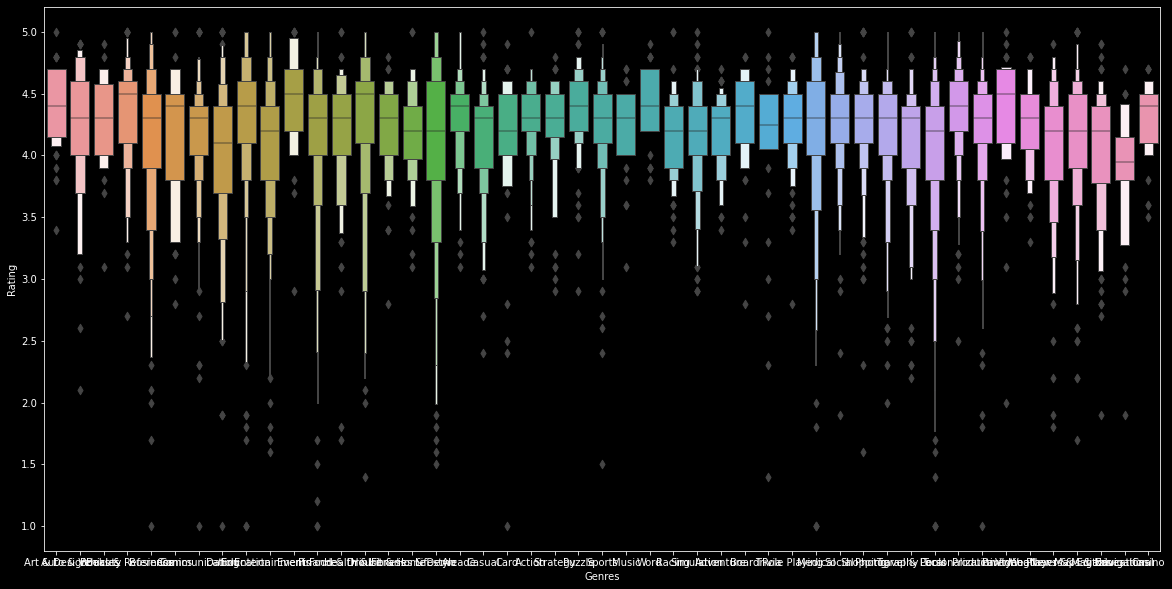

In [ ]:
a4_dims = (20, 10)
fig, ax = plt.subplots(figsize=a4_dims)
#sns.scatterplot(x='Genres', y=target, data=X.loc[~X['Genres'].str.contains(';', regex=False)] )
sns.boxenplot(x='Genres', y=target, data=X.loc[~X['Genres'].str.contains(';', regex=False)] )
plt.show()

The could have an impact. In order to conduct an analysis, I would need to construct a way to transform those multi-categorical sets into the mix. 

Do I want them to count twice? They have the same datapoints, but different ratings. How did this same content do when placed in the creativity bucket vs. the art and design bucket. That's the individual - as a whole; how does that impact the decision? Should they have selected on over the other? 

Does it make a difference?

The world may never know. 

In [ ]:
X = X.drop(columns='Genres')

### Last Updated

Oh. I have to convert these to a date, right? 

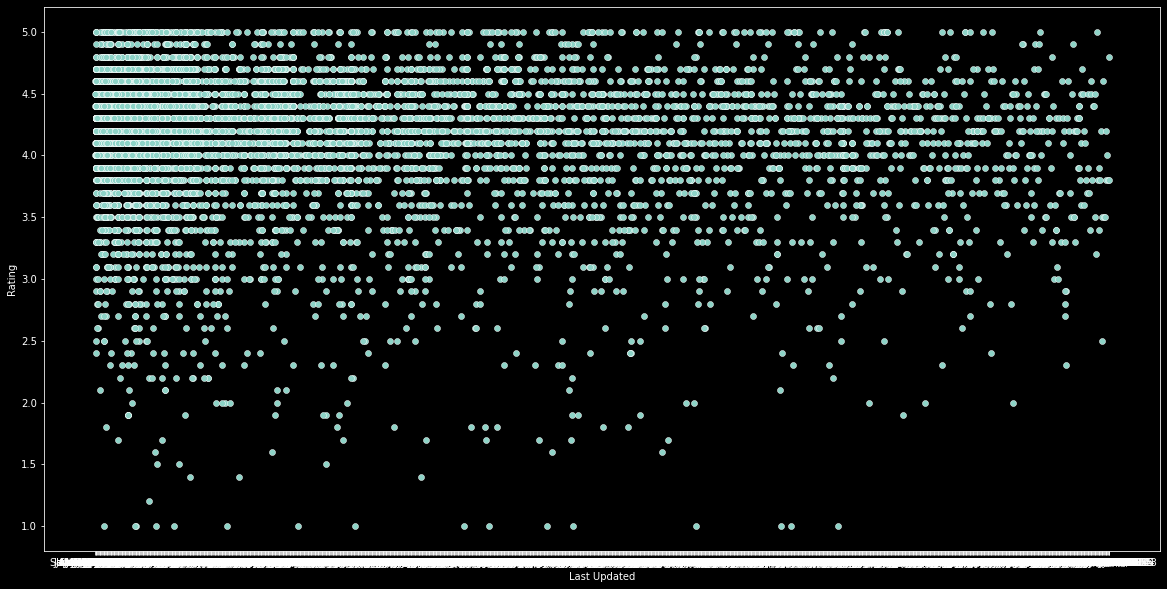

In [ ]:
a4_dims = (20, 10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(x='Last Updated', y=target, data=X)
plt.show()

In [ ]:
#What's the oldest one?
# convert the 'Date' column to datetime format
X['Last Updated'] = pd.to_datetime(X['Last Updated'])

In [ ]:
X['Last Updated'].max()

Timestamp('2018-08-08 00:00:00')

Turns out that my random forest doesn't like the date data type. She only likes floats. 

What's up with that? Who doesn't love a good date?

Anyway, I think I like this solution from [stack overflow.](https://stackoverflow.com/questions/24588437/convert-date-to-float-for-linear-regression-on-pandas-data-frame) 

In [ ]:
X['Last Updated'] = (X['Last Updated'] - X['Last Updated'].min())  / np.timedelta64(1,'D')

Do I need to look at these individually? Do I want to look at these individual portion? 

Mostly I'm thinking that the applications that have a more recent update are more user-friendly and probably have higher ratings. 

So I want to keep it as is. 

### Current Version

What am I going to do with that varies with device segment? This is a categorical value, I think - not a numerical value. Do I want to treat it as a numerical value?

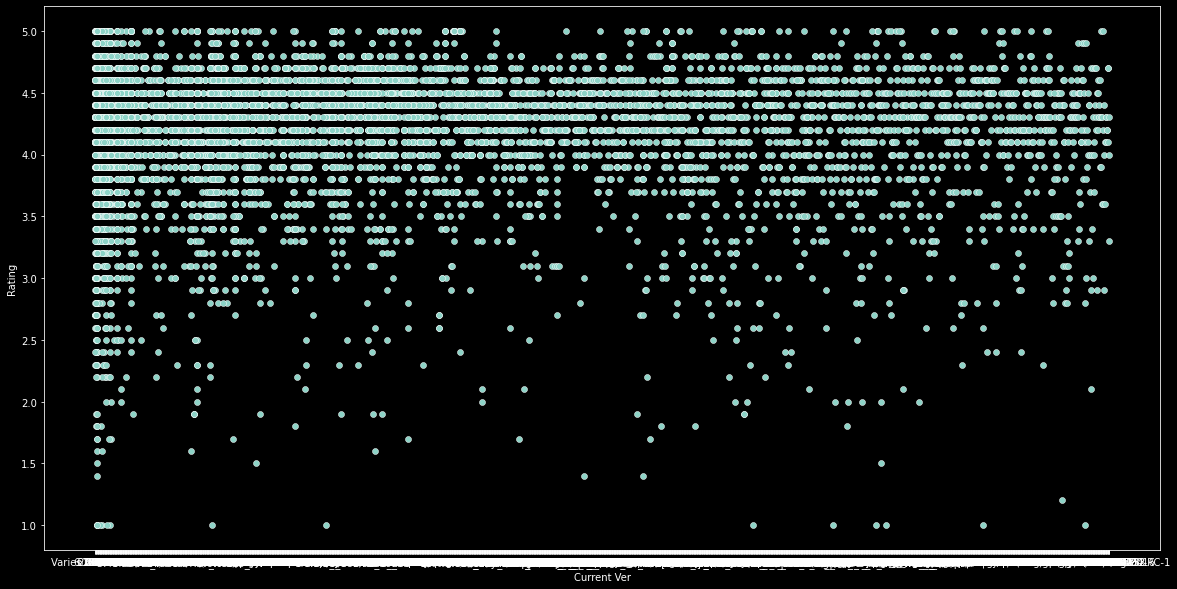

In [ ]:
#Adjust the size of the graph.
a4_dims = (20, 10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(x='Current Ver', y=target, data=X)
plt.show()

In [ ]:
X['Current Ver'].value_counts()

Varies with device    1415
1.0                    458
1.1                    194
1.2                    126
1.3                    120
                      ... 
10001008                 1
5.0.1.3                  1
11.1                     1
3.98                     1
2018-04-27               1
Name: Current Ver, Length: 2638, dtype: int64

I think I might like to just drop this one.

In [ ]:
X = X.drop(columns='Current Ver')

###Android Ver.

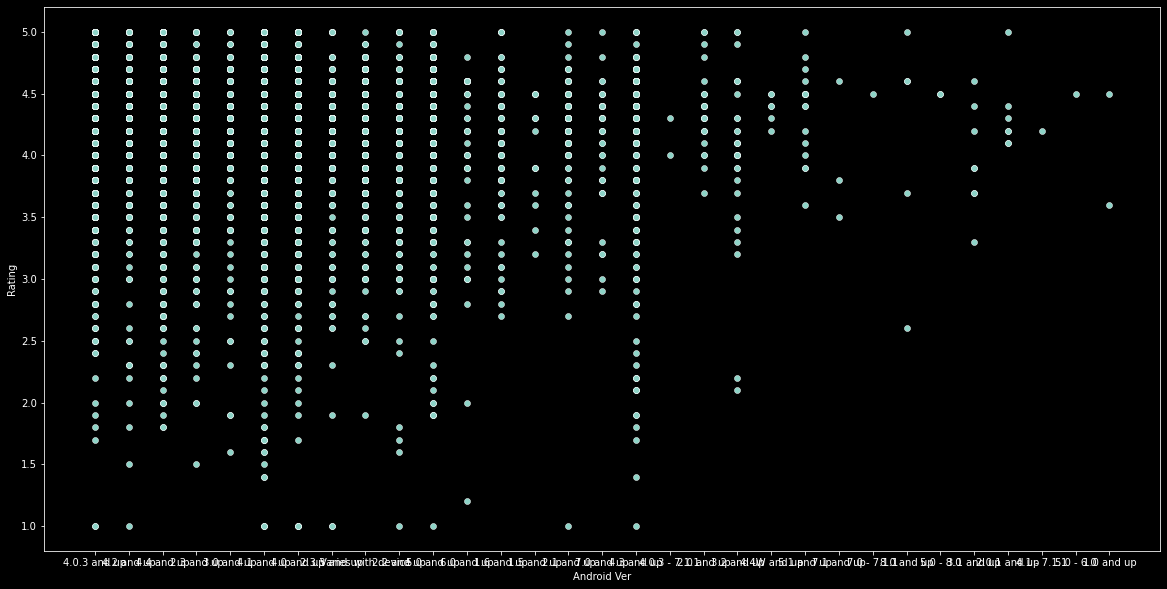

In [ ]:
#Adjust the size of the graph.
a4_dims = (20, 10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(x='Android Ver', y=target, data=X)
plt.show()

In [ ]:
X['Android Ver'].nunique()

31

In [ ]:
X['Android Ver'].loc[X['Android Ver'].str.contains('and up')].value_counts()

4.1 and up      2059
4.0.3 and up    1240
4.0 and up      1129
4.4 and up       875
2.3 and up       582
5.0 and up       535
4.2 and up       337
2.3.3 and up     240
3.0 and up       211
2.2 and up       208
4.3 and up       207
2.1 and up       113
1.6 and up        87
6.0 and up        48
7.0 and up        41
3.2 and up        31
2.0 and up        27
5.1 and up        18
1.5 and up        15
3.1 and up         8
2.0.1 and up       7
4.4W and up        6
8.0 and up         5
7.1 and up         3
1.0 and up         2
Name: Android Ver, dtype: int64

Intuitively I want to add everything that is 4 and up.
Then I want to add everything that is three and up. Etc.

There are a number of ways to do it, but for now. I want to do a hot dummy encode on this one and see what kind of trouble I get into.

In [ ]:
X = pd.get_dummies(X, columns=['Android Ver'], drop_first=True)

In [ ]:
X.head()

,Rating,Reviews,Installs,Price,Content Rating,Last Updated,Size_M,Size_V,Type_Paid,Android Ver_1.5 and up,Android Ver_1.6 and up,Android Ver_2.0 and up,Android Ver_2.0.1 and up,Android Ver_2.1 and up,Android Ver_2.2 and up,Android Ver_2.3 and up,Android Ver_2.3.3 and up,Android Ver_3.0 and up,Android Ver_3.1 and up,Android Ver_3.2 and up,Android Ver_4.0 and up,Android Ver_4.0.3 - 7.1.1,Android Ver_4.0.3 and up,Android Ver_4.1 - 7.1.1,Android Ver_4.1 and up,Android Ver_4.2 and up,Android Ver_4.3 and up,Android Ver_4.4 and up,Android Ver_4.4W and up,Android Ver_5.0 - 6.0,Android Ver_5.0 - 8.0,Android Ver_5.0 and up,Android Ver_5.1 and up,Android Ver_6.0 and up,Android Ver_7.0 - 7.1.1,Android Ver_7.0 and up,Android Ver_7.1 and up,Android Ver_8.0 and up,Android Ver_Varies with device
0,4.1,159,10000,0.0,4.1,2788.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3.9,967,500000,0.0,3.9,2796.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.7,87510,5000000,0.0,4.7,2994.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4.5,215644,50000000,0.0,4.5,2940.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4.3,967,100000,0.0,4.3,2952.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Rating                          9360 non-null   float64
 1   Reviews                         9360 non-null   int64  
 2   Installs                        9360 non-null   int64  
 3   Price                           9360 non-null   float64
 4   Content Rating                  9360 non-null   object 
 5   Last Updated                    9360 non-null   float64
 6   Size_M                          9360 non-null   uint8  
 7   Size_V                          9360 non-null   uint8  
 8   Type_Paid                       9360 non-null   uint8  
 9   Android Ver_1.5 and up          9360 non-null   uint8  
 10  Android Ver_1.6 and up          9360 non-null   uint8  
 11  Android Ver_2.0 and up          9360 non-null   uint8  
 12  Android Ver_2.0.1 and up        9

# Model Creation and Evaluation (Random Forest)
Create a random forest model and evaluate


In [ ]:
#Handle the target variable, which needs to be handled as an int.
y = X[target]
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

In [ ]:
X = X.drop(columns=target)

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score

#Size of the test set.
SIZE = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SIZE)
print('There are {:d} training samples and {:d} test samples'.format(X_train.shape[0], X_test.shape[0]))

There are 7488 training samples and 1872 test samples


In [ ]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = rfc.predict(X_test)

In [ ]:
import sklearn
#confusion matrix
print(sklearn.metrics.confusion_matrix(y_test, y_pred))

[[ 1  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ... 38  1  1]
 [ 0  0  0 ...  4  5  0]
 [ 0  0  0 ...  1  0 61]]


In [ ]:
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1
           7       1.00      0.33      0.50         3
           8       0.17      0.33      0.22         3
           9       0.00      0.00      0.00         3
          10       0.33      0.50      0.40         2
          11       0.00      0.00      0.00         7
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         7
          14       0.33      0.14      0.20         7
          15       0.17      0.20      0.18         5
          16       0.43      0.23      0.30        13
          17       0.00      0.00      0.00         9
          18       0.35      0.38      0.36        16
          19       0.23    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Feature ranking:
1. feature 3 (0.601146)
2. feature 0 (0.138164)
3. feature 4 (0.116211)
4. feature 1 (0.062529)
5. feature 2 (0.008789)
6. feature 23 (0.006607)
7. feature 19 (0.006588)
8. feature 21 (0.006160)
9. feature 26 (0.005930)
10. feature 5 (0.004951)
11. feature 30 (0.004424)
12. feature 24 (0.004157)
13. feature 14 (0.003718)
14. feature 7 (0.003415)
15. feature 25 (0.003335)
16. feature 6 (0.003104)
17. feature 37 (0.003011)
18. feature 15 (0.002954)
19. feature 16 (0.002863)
20. feature 13 (0.002455)
21. feature 12 (0.001620)
22. feature 9 (0.001489)
23. feature 32 (0.001418)
24. feature 34 (0.001105)
25. feature 18 (0.000937)
26. feature 10 (0.000567)
27. feature 31 (0.000552)
28. feature 8 (0.000524)
29. feature 17 (0.000272)
30. feature 36 (0.000263)
31. feature 35 (0.000237)
32. feature 27 (0.000156)
33. feature 11 (0.000126)
34. feature 20 (0.000079)
35. feature 28 (0.000047)
36. feature 33 (0.000040)
37. feature 22 (0.000039)
38. feature 29 (0.000018)


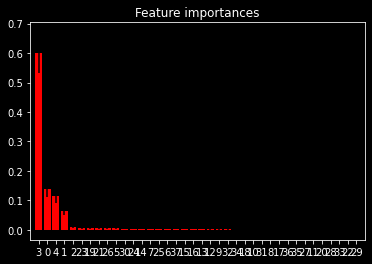

In [ ]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Validation and Tweaking
Using grid search cross validation, tweak the parameters to produce a better performing model


In [ ]:
grid = {'n_estimators':[50,60,70,80,90,100,110,120]}

from sklearn.model_selection import GridSearchCV

result = GridSearchCV(ensemble.RandomForestClassifier(), grid, cv=5)
result.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
print('best number of estimator: ',result.best_estimator_.n_estimators)
print('best score: ',result.best_score_)

best number of estimator:  100
best score:  0.8493606706069015


#[Display](https://youtu.be/-ffQBxz5D34) 
Show and discuss your results


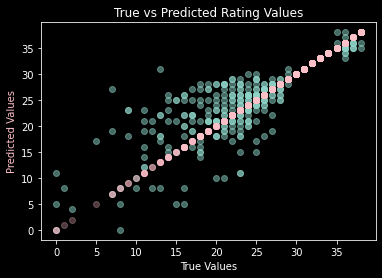

In [ ]:
plt.scatter(y_test, y_pred, alpha=.5)
plt.scatter(y_test, y_test, color='pink', alpha=.3)
plt.xlabel('True Values')
plt.ylabel('Predicted Values', color='pink')
plt.title('True vs Predicted Rating Values')
plt.show()